# Relationship Extraction

In this notebook, we will explore how to implement a Relation Extraction Model using BERT and Pytorch.

* Data for fine-tuning the RE comes from the [New York Times (NYT) Relation Extraction Dataset](https://www.kaggle.com/datasets/daishinkan002/new-york-times-relation-extraction-dataset) available on Kaggle.
* Unlike the XXXForTokenClassification model, which comes with a token classification head on top of some XXX transformer, there is no pre-built model for Relation Extraction. So we will build one where we use the Transformer as the encoder (body of the model) and we add a Relation Extraction head.


In [ ]:
!pip install transformers datasets seqeval

     |████████████████████████████████| 4.0 MB 7.5 MB/s 
     |████████████████████████████████| 325 kB 32.0 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 77 kB 5.2 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 6.5 MB 34.9 MB/s 
     |████████████████████████████████| 596 kB 35.3 MB/s 
     |████████████████████████████████| 1.1 MB 34.0 MB/s 
     |████████████████████████████████| 212 kB 34.9 MB/s 
     |████████████████████████████████| 136 kB 20.4 MB/s 
     |████████████████████████████████| 127 kB 38.7 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 144 kB 37.5 MB/s 
     |████████████████████████████████| 271 kB 40.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=4d884e6efd419f31000e17ada9089c64ba7c992a3d402fbf6bee8762d0eeb40b
  Stored in directory: /root/.cache/pip/whe

## Imports

In [ ]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re
import shutil
import torch
import torch.nn as nn

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, 
    classification_report, accuracy_score
)
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW

from transformers import (
    BertTokenizerFast, BertModel, BertForPreTraining, BertConfig, BertPreTrainedModel,
    DataCollatorWithPadding,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput

## Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GS_INPUT_DIR = "/content/drive/MyDrive/odsc-2022-data/NYT"
DATA_DIR = "./data"

BASE_MODEL_NAME = "bert-base-cased"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-nyt-re-v2".format(BASE_MODEL_NAME))

In [ ]:
!ls /content/drive/MyDrive/odsc-2022-data/NYT/

bert-base-cased-nyt-re	test.json  train.json  valid.json


## Input Data Format

In [ ]:
with open(os.path.join(GS_INPUT_DIR, "train.json"), "r") as fin:
  for line in fin:
    rec = json.loads(line.strip())
    break

print(json.dumps(rec, indent=2))

{
  "sentText": "Massachusetts ASTON MAGNA Great Barrington ; also at Bard College , Annandale-on-Hudson , N.Y. , July 1-Aug .",
  "articleId": "/m/vinci8/data1/riedel/projects/relation/kb/nyt1/docstore/nyt-2005-2006.backup/1669365.xml.pb",
  "relationMentions": [
    {
      "em1Text": "Annandale-on-Hudson",
      "em2Text": "Bard College",
      "label": "/location/location/contains"
    }
  ],
  "entityMentions": [
    {
      "start": 1,
      "label": "ORGANIZATION",
      "text": "Bard College"
    },
    {
      "start": 2,
      "label": "LOCATION",
      "text": "Annandale-on-Hudson"
    }
  ],
  "sentId": "1"
}


## Entity Types

In [ ]:
splits = ["train", "valid", "test"]
ent_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["entityMentions"]:
        label = ent_mention["label"]
        ent_counts[label][split] += 1

ent_df = pd.DataFrame.from_dict(ent_counts, orient="index").sort_values("train", ascending=False)
ent_df

,train,valid,test
LOCATION,119693,10703,10721
PERSON,41367,3727,3727
ORGANIZATION,16401,1493,1413


## Relation Types

In [ ]:
rel_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["relationMentions"]:
        label = ent_mention["label"].split("/")[-1]
        rel_counts[label][split] += 1

rel_df = pd.DataFrame.from_dict(rel_counts, orient="index").sort_values("train", ascending=False)
rel_df = rel_df[(rel_df["train"] > 1000) & (rel_df["train"] < 10000)]
rel_df

,train,valid,test
nationality,7198,643.0,589.0
capital,6718,616.0,708.0
place_lived,6362,539.0,612.0
country,5658,558.0,580.0
administrative_divisions,5658,558.0,580.0
company,4950,466.0,436.0
neighborhood_of,4941,469.0,394.0
place_of_birth,2813,228.0,270.0
place_of_death,1752,133.0,136.0


## Raw Dataset

In [ ]:
def reformat_json(infile, outfile, valid_relations):
  print("reformating {:s} -> {:s}".format(infile, outfile))
  fout = open(outfile, "w")
  with open(infile, "r") as fin:
    for line in fin:
      rec = json.loads(line.strip())
      text = rec["sentText"]
      entities = {}
      for entity_mention in rec["entityMentions"]:
        entity_text = entity_mention["text"]
        entity_type = entity_mention["label"][0:3]
        entities[entity_text] = entity_type
      for relation_mention in rec["relationMentions"]:
        label = relation_mention["label"].split("/")[-1]
        if label not in valid_relations:
          continue
        try:
          sub_text = relation_mention["em1Text"]
          sub_type = entities[sub_text]
          obj_text = relation_mention["em2Text"]
          obj_type = entities[obj_text]
          
          # assumption: em1Text == SUBJECT and occurs before em2Text == OBJECT
          sub_start = text.find(sub_text)
          sub_end = sub_start + len(sub_text)
          text_pre = text[:sub_start]
          text_sub = "<S:{:s}> {:s} </S:{:s}>".format(sub_type, sub_text, sub_type)
          obj_start = text.find(obj_text, sub_end)
          obj_end = obj_start + len(obj_text)
          text_mid = text[sub_end:obj_start]
          text_obj = "<O:{:s}> {:s} </O:{:s}>".format(obj_type, obj_text, obj_type)
          text_post = text[obj_end:]
          text = text_pre + text_sub + text_mid + text_obj + text_post

          tokens = text.split()
          output = {
              "tokens": tokens,
              "label": label
          }
          
          fout.write(json.dumps(output) + "\n")
        except:
          pass
  fout.close()


os.makedirs(DATA_DIR, exist_ok=True)

valid_relations = set([
  "nationality", "capital", "place_lived", "country", "administrative_divisions",
  "company", "neighborhood_of", "place_of_birth", "place_of_death"
])

for i, split in enumerate(splits):
  reformat_json(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)),
                os.path.join(DATA_DIR, "{:s}.json".format(split)), 
                valid_relations=valid_relations)

reformating /content/drive/MyDrive/odsc-2022-data/NYT/train.json -> ./data/train.json
reformating /content/drive/MyDrive/odsc-2022-data/NYT/valid.json -> ./data/valid.json
reformating /content/drive/MyDrive/odsc-2022-data/NYT/test.json -> ./data/test.json


In [ ]:
data_files = {split: os.path.join(DATA_DIR, "{:s}.json".format(split)) for split in splits}
nyt_dataset = load_dataset("json", data_files=data_files)
nyt_dataset

Using custom data configuration default-53ba32a25052cac4


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-53ba32a25052cac4/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 45860
    })
    valid: Dataset({
        features: ['tokens', 'label'],
        num_rows: 4182
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 4277
    })
})

### Label Distribution

In [ ]:
nyt_dataset.set_format(type="pandas")
nyt_df = nyt_dataset["train"][:]
nyt_df.head()

,tokens,label
0,"[It, will, be, the, final, movie, credited, to...",place_of_birth
1,"[Under, pressure, from, Mr., Kerkorian, and, o...",company
2,"[Mr., Ferrer, still, holds, commanding, leads,...",place_lived
3,"[Mr., Ferrer, still, holds, commanding, leads,...",place_lived
4,"[United, States, Representative, <S:PER>, Char...",place_of_birth


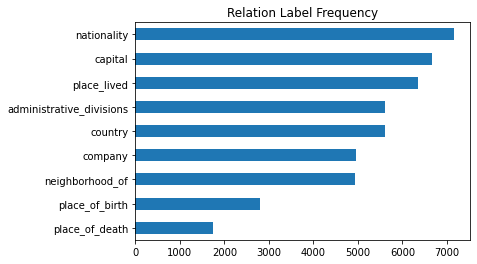

In [ ]:
nyt_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Relation Label Frequency")
_ = plt.show()

### Sentence Length Distribution

Box plots below shows that we can safely ignore sentences that are over 100 tokens in length.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


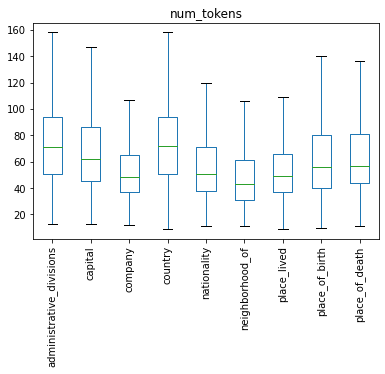

In [ ]:
nyt_df["num_tokens"] = nyt_df["tokens"].apply(len)
nyt_df.boxplot("num_tokens", by="label", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
_ = plt.show()

In [ ]:
nyt_dataset.reset_format()

## Tokenizer

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Add Entity Marker Tokens

In [ ]:
marker_tokens = []
entity_types = ["LOC", "PER", "ORG"]
for entity_type in entity_types:
  marker_tokens.append("<S:{:s}>".format(entity_type))
  marker_tokens.append("</S:{:s}>".format(entity_type))
  marker_tokens.append("<O:{:s}>".format(entity_type))
  marker_tokens.append("</O:{:s}>".format(entity_type))

tokenizer.add_tokens(marker_tokens)

12

## Encoded Dataset

In [ ]:
valid_relations = sorted(list(valid_relations))
rel_tags = ClassLabel(names=valid_relations)
label2id = {name: rel_tags.str2int(name) for name in valid_relations}
id2label = {id: rel_tags.int2str(id) for id in range(len(valid_relations))}

# label2id, id2label

In [ ]:
def encode_data(examples):
  tokenized_inputs = tokenizer(examples["tokens"],
                               is_split_into_words=True,
                               truncation=True)
  span_idxs = []
  for input_id in tokenized_inputs.input_ids:
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    span_idxs.append([
      [idx for idx, token in enumerate(tokens) if token.startswith("<S:")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("</S:")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("<O:")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("</O:")][0]
    ])
  tokenized_inputs["span_idxs"] = span_idxs
  tokenized_inputs["labels"] = [label2id[label] for label in examples["label"]]
  return tokenized_inputs

encoded = encode_data(nyt_dataset["train"][0:5])
encoded.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'])

In [ ]:
MAX_LENGTH = 100
encoded_nyt_dataset = (nyt_dataset
                       .filter(lambda example: len(example["tokens"]) < MAX_LENGTH)
                       .map(encode_data, batched=True, remove_columns=["tokens", "label"]))
encoded_nyt_dataset

  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/41 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 40126
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 3656
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 3713
    })
})

In [ ]:
rec = encoded_nyt_dataset["train"][0:5]
print("rec.labels:", rec["labels"])
print("rec.input_ids:", len(rec["input_ids"]), len(rec["input_ids"][0]))
print("rec.span_idxs:", rec["span_idxs"])

rec.labels: [7, 2, 6, 6, 7]
rec.input_ids: 5 44
rec.span_idxs: [[9, 13, 21, 25], [31, 36, 42, 44], [22, 28, 30, 32], [22, 29, 32, 34], [4, 10, 23, 27]]


## DataLoader

In [ ]:
BATCH_SIZE = 16

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_nyt_dataset["train"], 
                      shuffle=True, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(encoded_nyt_dataset["valid"], 
                      shuffle=False, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["valid"].num_rows, 200).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(encoded_nyt_dataset["test"], 
                     shuffle=False,
                    #  sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["test"].num_rows, 100).tolist()),
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)

## Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BertForRelationExtraction(BertPreTrainedModel):
  def __init__(self, config, num_labels):
    super(BertForRelationExtraction, self).__init__(config)
    self.num_labels = num_labels
    # body
    self.bert = BertModel(config)
    # head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.layer_norm = nn.LayerNorm(config.hidden_size * 2)
    self.linear = nn.Linear(config.hidden_size * 2, self.num_labels)
    self.init_weights()

  def forward(self, input_ids, token_type_ids, attention_mask,
              span_idxs, labels=None):
    outputs = (
        self.bert(input_ids, token_type_ids=token_type_ids,
                  attention_mask=attention_mask,
                  output_hidden_states=False)
            .last_hidden_state)
            
    sub_maxpool, obj_maxpool = [], []
    for bid in range(outputs.size(0)):
      # span excludes entity markers, maxpool across span
      sub_span = torch.max(outputs[bid, span_idxs[bid, 0]+1:span_idxs[bid, 1], :], 
                           dim=0, keepdim=True).values
      obj_span = torch.max(outputs[bid, span_idxs[bid, 2]+1:span_idxs[bid, 3], :],
                           dim=0, keepdim=True).values
      sub_maxpool.append(sub_span)
      obj_maxpool.append(obj_span)

    sub_emb = torch.cat(sub_maxpool, dim=0)
    obj_emb = torch.cat(obj_maxpool, dim=0)
    rel_input = torch.cat((sub_emb, obj_emb), dim=-1)

    rel_input = self.layer_norm(rel_input)
    rel_input = self.dropout(rel_input)
    logits = self.linear(rel_input)

    if labels is not None:
      loss_fn = nn.CrossEntropyLoss()
      loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
      return SequenceClassifierOutput(loss, logits)
    else:
      return SequenceClassifierOutput(None, logits)


# config = BertConfig()
# model = BertForRelationExtraction(config, num_labels=len(valid_relations))
# for batch in train_dl:
#   # output = model(batch["input_ids"], batch["token_type_ids"], batch["attention_mask"],
#   #                batch["span_idxs"], batch["labels"])
#   outputs = model(**batch)
#   break

# print("loss:", outputs.loss, "logits.size:", outputs.logits.size())

## Training Loop

In [ ]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 3

In [ ]:
config = BertConfig()
model = BertForRelationExtraction(config, num_labels=len(valid_relations))
model = model.to(device)

optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

In [ ]:
def compute_accuracy(labels, logits):
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  return accuracy_score(labels_cpu, preds_cpu)


def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_accuracy(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches
  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()


## Training / Fine-tuning

In [ ]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, val-acc: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

EPOCH 1, train loss: 1486.891, val loss: 98.542, val-acc: 0.83133
EPOCH 2, train loss: 881.609, val loss: 81.793, val-acc: 0.84170
EPOCH 3, train loss: 674.648, val loss: 75.296, val-acc: 0.84607


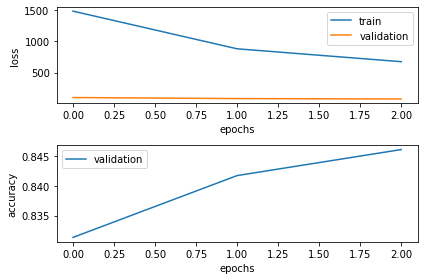

In [ ]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

In [ ]:
ytrue, ypred = [], []
for batch in test_dl:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
      predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
      labels = batch["labels"].cpu().numpy()
      ytrue.extend(labels)
      ypred.extend(predictions)

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

test accuracy: 0.845


In [ ]:
print(classification_report(ytrue, ypred, target_names=valid_relations))

                          precision    recall  f1-score   support

administrative_divisions       0.72      0.77      0.74       463
                 capital       0.81      0.77      0.79       597
                 company       0.96      0.98      0.97       409
                 country       0.97      0.97      0.97       458
             nationality       0.88      0.93      0.90       527
         neighborhood_of       0.98      0.99      0.98       364
             place_lived       0.85      0.84      0.85       562
          place_of_birth       0.58      0.51      0.54       223
          place_of_death       0.38      0.35      0.36       110

                accuracy                           0.85      3713
               macro avg       0.79      0.79      0.79      3713
            weighted avg       0.84      0.85      0.84      3713



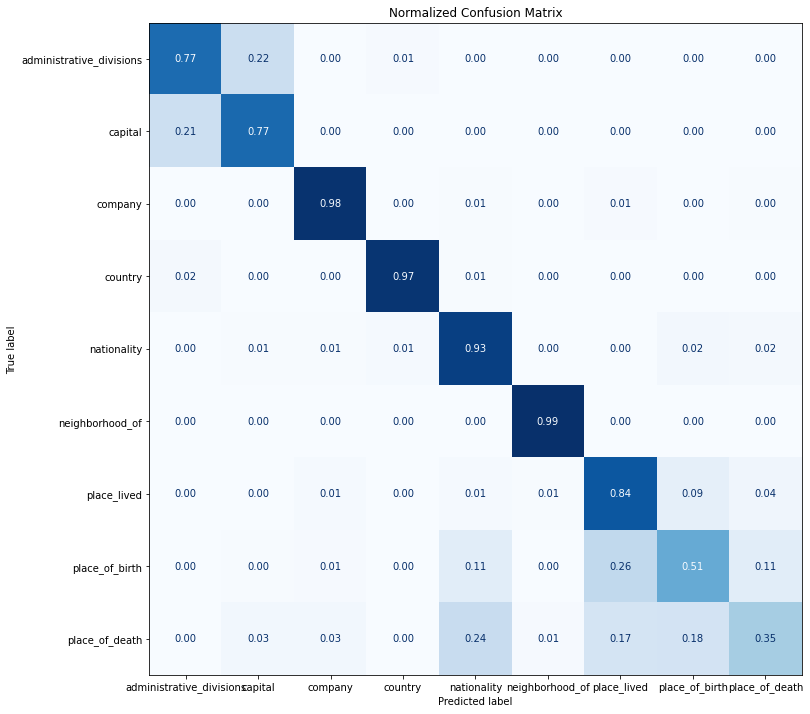

In [ ]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


plot_confusion_matrix(ytrue, ypred, valid_relations)

## Save Model

In [ ]:
!cp -r data/bert-base-cased-nyt-re/ /content/drive/MyDrive/odsc-2022-data/NYT/

cp: cannot stat 'data/bert-base-cased-nyt-re/': No such file or directory


In [ ]:
!ls /content/drive/MyDrive/odsc-2022-data/NYT/bert-base-cased-nyt-re/

ckpt-1	ckpt-2	ckpt-3	history.tsv
